# Taxi Trips and Traffic

Where most models use real-time data from users to predict arrival
times at any given moment, we believe they could be improved by including a predictive
element. Our intent is to use the NYC Taxi and Limousine Commission's yellow and green cab data set to estimate density of pickup and dropoffs at any given place and time. We will then use the density as a proxy for traffic to estimate the time it takes to arrive at a destination.

In [1]:
%matplotlib inline
import edward as ed
from edward.models import Normal
import pandas as pd
pd.set_option('float_format', '{:f}'.format)
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# our functions
import setup
import data
import visualizations
import basis_functions
setup.set_random_seeds(42)
plt.style.use("seaborn-talk")
sns.set_context("talk")

## Data

We used the
[2015 NYC Yellow Cab Dataset](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml),
which consists of pickup and dropoff coordinates for trips, along 
with metadata like cost, distance, and number of passengers.

In [2]:
manhattan = data.get_borough_data("data/preprocessed.csv", "Manhattan")
ues_to_msh = data.get_neighborhood_to_neighborhood("Morningside Heights", "Upper East Side-Carnegie Hill", manhattan)

In [3]:
clean_ues_to_msh = data.clean_data(ues_to_msh)
clean_with_cols_ues_to_msh = data.add_handy_columns(clean_ues_to_msh)

In [4]:
weekdays = clean_with_cols_ues_to_msh.where(clean_with_cols_ues_to_msh["pickup_day_of_week"] <= 4).dropna().reset_index(drop=True)
weekends = clean_with_cols_ues_to_msh.where(clean_with_cols_ues_to_msh["pickup_day_of_week"] > 4).dropna().reset_index(drop=True)

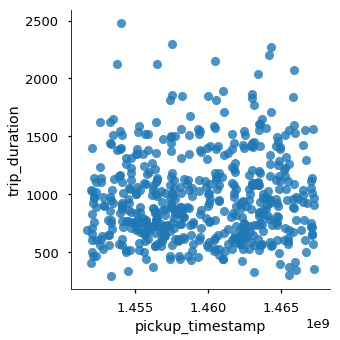

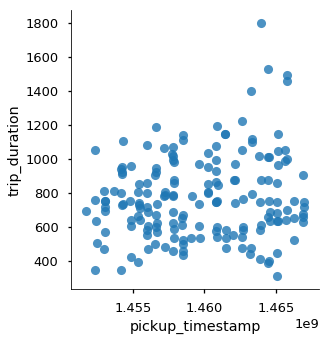

In [5]:
sns.lmplot(x="pickup_timestamp", y="trip_duration", data=weekdays, fit_reg=False)
sns.lmplot(x="pickup_timestamp", y="trip_duration", data=weekends, fit_reg=False)
plt.show()

# Model

In [18]:
test_indices = np.random.choice(weekdays.shape[0], size=int(weekdays.shape[0] * 0.1), replace=False)

indicator_cols = ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude", "manhattan_distance", "pickup_hour", "pickup_timestamp"]

# polynomial basis function
x_test = data.standardize_cols(basis_functions.polynomial(weekdays.iloc[test_indices][indicator_cols], degree=2))
y_test = weekdays.iloc[test_indices]["trip_duration"]

x_train = data.standardize_cols(basis_functions.polynomial(weekdays.drop(test_indices)[indicator_cols], degree=2))
y_train = weekdays.drop(test_indices)["trip_duration"]

y_train_min = y_train / 60
y_test_min = y_test / 60

N, D = x_train.shape
X = tf.placeholder(tf.float32, [None, D])
w = ed.models.Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = ed.models.Normal(loc=[0.0], scale=1.0)
alpha = ed.models.Normal(loc=[0.0], scale=1.0)
Y = ed.models.Normal(loc=ed.dot(X, w) + b, scale=alpha)

qalpha = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.zeros([1])),
                                                   tf.Variable(tf.zeros([1]))),
    bijector=tf.contrib.distributions.bijectors.Exp())

qw = ed.models.NormalWithSoftplusScale(loc=tf.Variable(tf.random_normal([D])),
                                       scale=tf.Variable(tf.random_normal([D])))

qb = ed.models.NormalWithSoftplusScale(loc=tf.Variable(tf.random_normal([1])),
                                       scale=tf.Variable(tf.random_normal([1])))

inference = ed.KLqp({w: qw, b: qb, alpha: qalpha}, data={X: x_train.as_matrix(), Y: y_train_min.as_matrix()})
inference.run(n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 1958.6220s | Loss: 2030


# Critique

In [15]:
y_post = Normal(loc=ed.dot(X, qw) + qb, scale=qalpha)

In [16]:
ed.evaluate("mean_absolute_error", data={X: x_test.as_matrix(),
                                         y_post: y_test_min.as_matrix()})

10.715083

In [ ]:
T = lambda ws, bs, alphas: max(ws[w])
ed.ppc(T, data={})

# Visualize the model

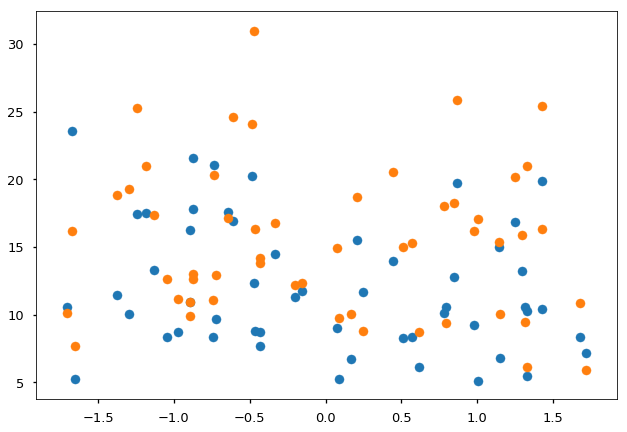

In [17]:
w = qw.sample(1).eval()
b = qb.sample(1).eval()
alpha = qalpha.sample(1).eval()
y_pred = np.dot(x_test.as_matrix(), w.T) + alpha
plt.scatter(x_test["pickup_timestamp"], y_pred)
plt.scatter(x_test["pickup_timestamp"], y_test_min)
plt.show()

### Results of a Linear Model
On average we have an absolute error of about 5:30 for each trip and the overall fit is not especially good.